# Using k-nearest neighbours to classify handwritten digits (mnist) dataset


In the following set of notebooks, we shall establish a pipeline to classify mnist data using a nearest neighbour approach. The objective is to understand the flow of Bluedata ML Ops pipeline. There are three key stages in developing the model:


1. Clean and convert data into a CSV file. 
2. Apply dimensionality reduction on the training data 
3. Train a kNN model to classify the test data 

___
___

**This notebook shall illustrate stage 1 and 2. The third stage is part of the later notebook**

____

## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn import decomposition
import pickle
import matplotlib.pyplot as plt

# nfs path is used as a common repository to store code, data and ML models
nfs_path = "/bd-fs-mnt/sj_ai_ml/"

## Pre-processing
### Convert raw format to a csv

The [mnist dataset](http://yann.lecun.com/exdb/mnist/) is in a non-text format and we use the code from [this github repo](https://github.com/pjreddie/mnist-csv-png) to convert it into a CSV.

In [2]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

In [3]:
#convert training data to csv
convert( nfs_path + "data/train-images", nfs_path + "data/train-labels",
        nfs_path + "data/mnist_train.csv", 60000)

In [4]:
#convert test data to csv
convert(nfs_path + "data/test-images", nfs_path + "data/test-labels",
        nfs_path + "data/mnist_test.csv", 10000)

### Load data

Now, we load the training and test data into memory


In [5]:
train_data = np.loadtxt(nfs_path + "data/mnist_train.csv", delimiter=",")
test_data = np.loadtxt(nfs_path + "data/mnist_test.csv", delimiter=",")

### Split data and labels

In [6]:
train_label, train_data = np.array_split(train_data, [1], axis = 1)
test_label, test_data = np.array_split(test_data, [1], axis = 1)

### Normalize the data

In [7]:
train_data = train_data/255.
test_data = test_data/255.

## Dump data and labels

We save the data and labels to the disk. We now have the decomposition PCA model fitted with training data, and the original CSV files.

In [8]:
np.save(nfs_path + "data/train_label", train_label)
np.save(nfs_path + "data/train_data", train_data)
np.save(nfs_path + "data/test_label", test_label)
np.save(nfs_path + "data/test_data", test_data)


## Decompose the training data

We now assess the decomposition to see the optimum number of features that would help balance the accuracy. For our example, we assume that 200 components with an explained variance of 96.67% are sufficient to get an accuracy good enough for the model. 

Text(0, 0.5, 'cumulative explained variance')

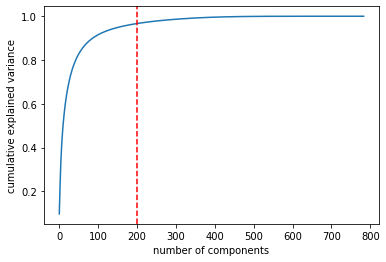

In [9]:
pca = decomposition.PCA()
pca.fit(train_data)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(x=200, color="r", linestyle="--")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

## Decompose the data on Training Cluster and Save the model

We now have the PCA parameters required to decompose the training data. We do this in the training environment using the **%%** attachments.

_**Note**: Storing/Saving a model with Standalone Jupyter Notebook Environment may make it incompatible with the Model Serving Engine (Endpoint Wrapper). It is recommended to use Training Environment (BlueData magics commands) in conjunction with Jupyter Notebook to store/save a model that is to be used for serving._

In [10]:
%attachments

Training Cluster    ML Engine
------------------  -----------
knntraining         python


In [11]:
%%knntraining
# We run the code directly into the training cluster with the help of the "%%" magic command

# Imports
import numpy as np
import pandas as pd
from sklearn import decomposition
import pickle

# nfs path is used as a common repository to store code, data and ML models
nfs_path = "/bd-fs-mnt/sj_ai_ml/"

# Load training data
train_data = np.load(nfs_path + "data/train_data.npy")

# We define a function to fit a PCA decomposition over the given data 
# and decompose it to the number of components specified as n_dim
# We then save the model to the save_path as a pickle dump
def pca_fit_and_dump(n_dim, data, save_path):
    pca = decomposition.PCA(n_components=n_dim)
    pca.fit(data)
    with open(save_path, "wb") as f:
        pickle.dump(pca, f)
    return pca
pca_fit_and_dump(200, train_data, nfs_path + "models/pca_mnist.p")

History URL: http://bluedata-14.bdlocal:10001/history/8


In [13]:
%logs --url http://bluedata-13.bdlocal:10001/history/8

Job Status: Finished




